In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sktime.utils.plotting import plot_series as ploting_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

The Missing Values can be interpolated, in the cases where a car has only Either Entry data , or exit data.

On observing the original data it was found that on the number of vehicles counted by camera '1' and camera '2' are same. 

Those cars whose either entry or exit is missing, either exit or entry respectively were deteced during the car maintainance, they were assigned those value 

Example : Suppose a Car has vehicle number 'MH1' and it's entry was marked , however it's exit was not marked , so we find the nearest time adter it's marked entry where camera 2 (The one that records exit) has undergone maintainance and we give it's exit that value.

Also Note : All this data filling is done for the avg time spent by vehicle data to be more continous.

In [2]:
# Function to plot ACF and PACF in a 1x2 subplot
def plot_acf_pacf(data, lags):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_acf(data, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation (ACF)')
    
    plot_pacf(data, lags=lags, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation (PACF)')
    
    plt.tight_layout()
    plt.show()

In [3]:
# Function to calculate MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)[1:]
    mae_naive = np.mean(np.abs(y_train[1:] - naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

In [4]:

# Function to plot the time series
def plot_series(train, test, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label="Train Data")
    plt.plot(test.index, test, label="Test Data", color='orange')
    plt.plot(test.index, forecast, label="Forecast", color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [6]:
def forecast_arima(model_fit,test_len):
    forecast= model_fit.forecast(steps=test_len+1)
    forecast.sort_index(inplace=True)
    return forecast


In [7]:

def plot_forecasted_Data(data,months_to_predict,model_fit) :
    forecasted_data = forecast_arima(model_fit,months_to_predict)
    # Plotting for visualization of the forecasted data 
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data, label='Train', color='blue')
    plt.plot(forecasted_data.index, forecasted_data, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast vs Actual')
    plt.show()
    return forecasted_data

First doing the preproccessing for vehicles per day part

In the data given their no as such missing values for the vehicles per day part So I am just doing the outliers smoothing part

The two methods to detect outliers were : 
1. The method I used for Outlier Detection is rolling zscore outlier check, I have set the threshold for 1.5.

2. Implemented the Interquartile Range (IQR) Method to detect the outlier

3. Now after detecting the outliers, using the moving average to fill those values for smoothing purposes.

4. Also when using the IQR method I have used interplotaion for smoothing purposes 


In [8]:
# Load the parking lot data
df = pd.read_csv('./parkingLot.csv')

# Now processing the data
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Now vehicles per day has the count for number of vehicles per day
df_entry = df[df['camera_id'] == 1].copy()
vehicles_per_day = df_entry.groupby(df_entry['timestamp'].dt.date).size().asfreq('D')
vehicles_per_day.index.name = 'date'

In [9]:
# This Method implemnts the rolling outlier check for the data
def rolling_outlier_check(df, value_col, window=5, threshold=1.5):
    rolling_mean = df[value_col].rolling(window).mean()
    rolling_std = df[value_col].rolling(window).std()
    df['is_outlier'] = (df[value_col] > rolling_mean + threshold * rolling_std) | (df[value_col] < rolling_mean - threshold * rolling_std)
    return df


In [10]:
def detect_outliers_iqr(df, value_col):
    Q1 = df[value_col].quantile(0.25)
    Q3 = df[value_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df['is_outlier'] = (df[value_col] < lower_bound) | (df[value_col] > upper_bound)
    return df


In [11]:
def remove_outliers(df,value_col,window=5,threshold=1.5):
    df[value_col] = df[value_col].where(~df['is_outlier'], df[value_col].rolling(window, center=True, min_periods=1).mean())
    df = df.drop(columns=['is_outlier'])  
    return df

In [12]:
def remove_outliers_interpolate(df, value_col, threshold=1.5):
    # Replace outlier values with NaN
    df[value_col] = df[value_col].where(~df['is_outlier'], other=pd.NA)
    # Replcae those nan with interpolation
    df[value_col] = df[value_col].interpolate(method='linear', limit_direction='both')
    df = df.drop(columns=['is_outlier'])  
    return df

In [13]:
vehicles_per_day = pd.DataFrame(vehicles_per_day) # Converting to a dataframe type
vehicles_per_day['is_outlier'] = False 
vehicles_per_day = vehicles_per_day.rename(columns={0: 'vehicles_per_day'})

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='vehicles_per_day'>)

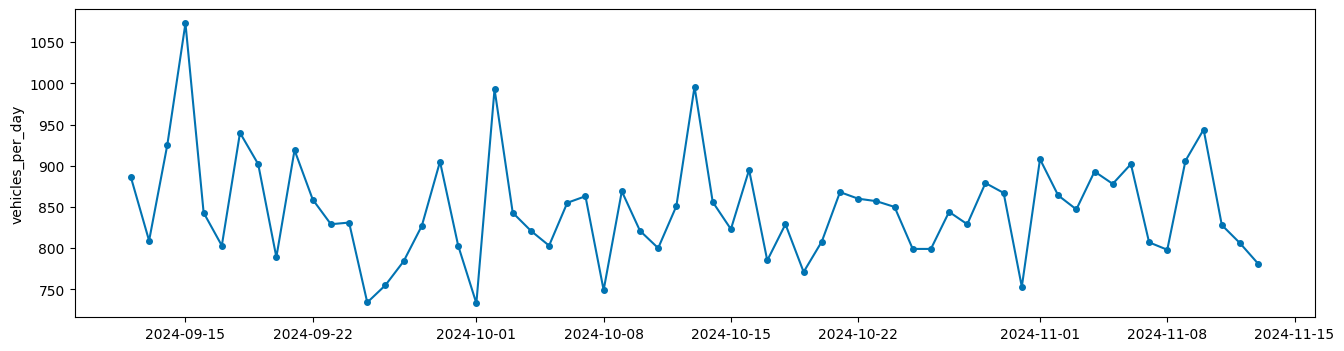

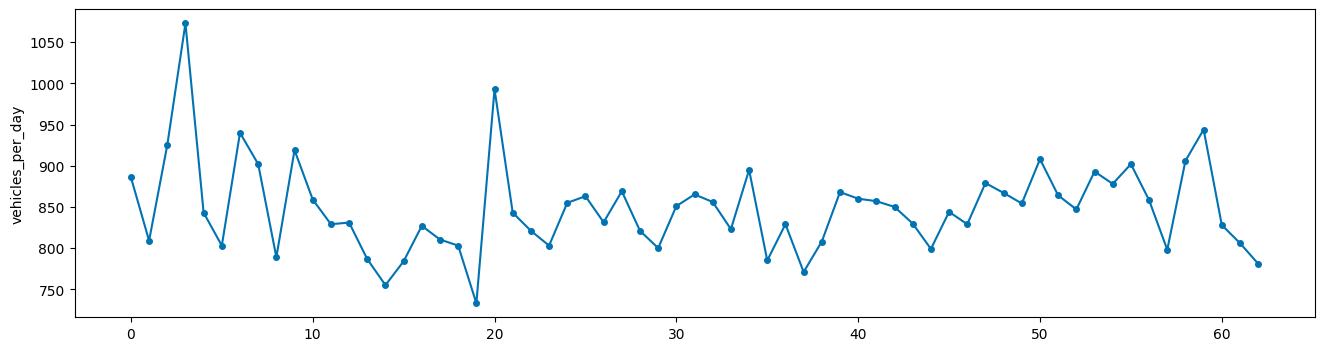

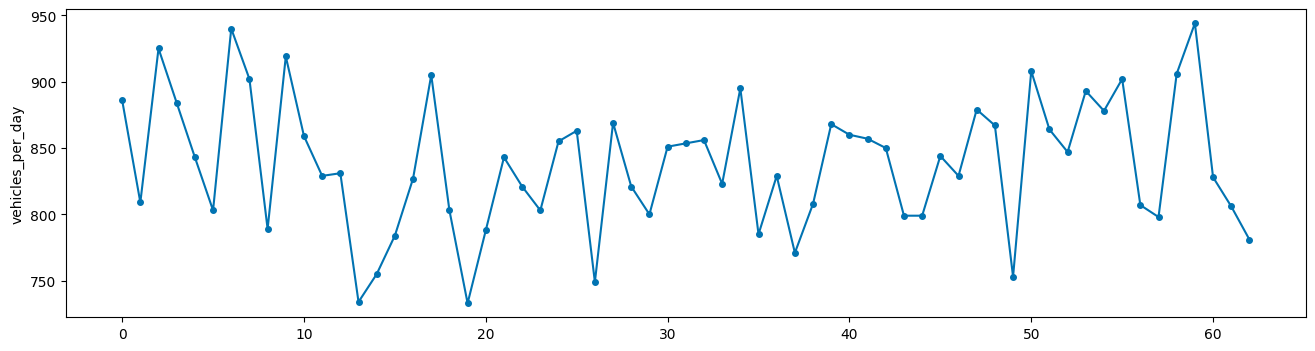

In [14]:
# Implementing the rolling (zscore outlier detection and moving rolling average) and (IQR along with interpolation) and plotting the forecast and reporting the MAPE for this, plotting side by side to compre these methods 
vehicles_per_day_cleaned = rolling_outlier_check(vehicles_per_day,'vehicles_per_day').reset_index(drop=True)
vehicles_per_day_cleaned = remove_outliers(vehicles_per_day_cleaned,'vehicles_per_day')

vehicles_per_day_cleaned_iqr = detect_outliers_iqr(vehicles_per_day,'vehicles_per_day').reset_index(drop=True)
vehicles_per_day_cleaned_iqr = remove_outliers_interpolate(vehicles_per_day_cleaned_iqr,'vehicles_per_day')

vehicles_per_day = vehicles_per_day.drop(columns=['is_outlier'])

# This is the first plot and is for the normal data
ploting_series(vehicles_per_day)

# These are with smoothing (rolling zscore,moving average) 
ploting_series(vehicles_per_day_cleaned)

# These are with smoothing (IQR,interpolation) 
ploting_series(vehicles_per_day_cleaned_iqr)


In [15]:
# Now making prediction for all the three and plotting their forecast along with, MAPE values for the best fit 
def train_test(vehicles_per_day) : 
    # Split data into training and testing sets
    train_size = int(len(vehicles_per_day) * 0.8)
    train_data, test_data = vehicles_per_day[:train_size], vehicles_per_day[train_size:]

    # Ensure the index has a frequency for ARIMA
    train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='D')
    test_data.index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')

    return train_data, test_data


In [16]:

# ARIMA model for forecasting vehicles entering
def best_p_d_q_mape(train_data,test_data):
    mape_min = 100
    best_p = 0  
    best_q = 0
    best_d = 0
    for d in range(0,2) : 
        for p in range(0,6) : 
            for q in range(0,6) : 
                arima_model = ARIMA(train_data, order=(p, d, q) , seasonal_order=(1,1,1,7))
                arima_result = arima_model.fit()
                arima_forecast = arima_result.forecast(steps=len(test_data))
                mape_val = mape(test_data, arima_forecast)
                if mape_val < mape_min : 
                    mape_min = mape_val
                    best_p = p
                    best_q = q
                    best_d = d

    return best_p , best_d , best_q , mape_min

train_data_cleaned , test_data_cleaned = train_test(vehicles_per_day_cleaned)
train_data_cleaned_iqr , test_data_cleaned_iqr = train_test(vehicles_per_day_cleaned_iqr)

# Best p q d for the 
best_p_cleaned , best_q_cleaned , best_d_cleaned , mape_min_cleaned  = best_p_d_q_mape(train_data_cleaned,test_data_cleaned)  

best_p_cleaned_iqr , best_q_cleaned_iqr , best_d_cleaned_iqr , mape_min_cleaned_iqr  = best_p_d_q_mape(train_data_cleaned_iqr,test_data_cleaned_iqr)  

In [17]:

train_data_cleaned , test_data_cleaned = train_test(vehicles_per_day_cleaned)
train_data_cleaned_iqr , test_data_cleaned_iqr = train_test(vehicles_per_day_cleaned_iqr)

# Best p q d for the rolling zscore method
best_p_cleaned , best_q_cleaned , best_d_cleaned , mape_min_cleaned  = best_p_d_q_mape(train_data_cleaned,test_data_cleaned)  

# Best p q d for the IQR interpolation method 
best_p_cleaned_iqr , best_q_cleaned_iqr , best_d_cleaned_iqr , mape_min_cleaned_iqr  = best_p_d_q_mape(train_data_cleaned_iqr,test_data_cleaned_iqr)  

In [18]:
# Now plotting them and forecasting them 
def arima_model_forecasted_val(train_data,test_data,best_p,best_d,best_q,P=1,Q=1,D=1,S=7) : 
    arima_model = ARIMA(train_data, order=(best_p, best_d, best_q) , seasonal_order=(P,D,Q,S))
    arima_result = arima_model.fit()
    arima_forecast = arima_result.forecast(steps=len(test_data))
    plot_series(train_data, test_data, arima_forecast, "ARIMA Forecast of Vehicles Entering Per Day")
    print("ARIMA MASE:", mase(test_data.values, arima_forecast.values, train_data.values))
    print("ARIMA MAPE:", mape(test_data.values, arima_forecast.values))
    return  mape(test_data.values, arima_forecast.values)

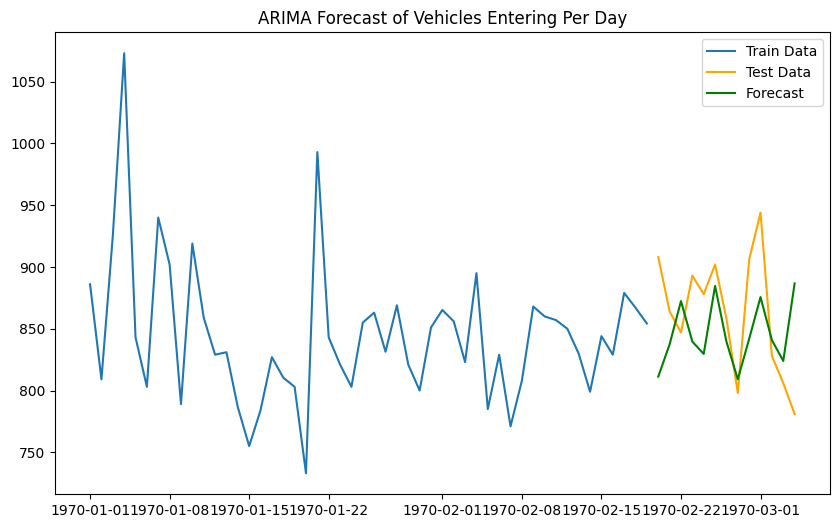

ARIMA MASE: 0.8519818845902318
ARIMA MAPE: 5.410535780001478


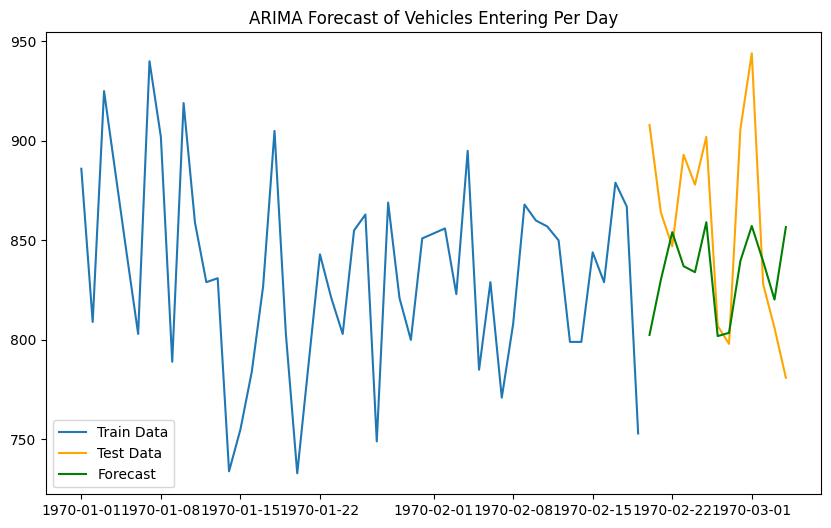

ARIMA MASE: 0.9506052212349856
ARIMA MAPE: 5.6609164329805335


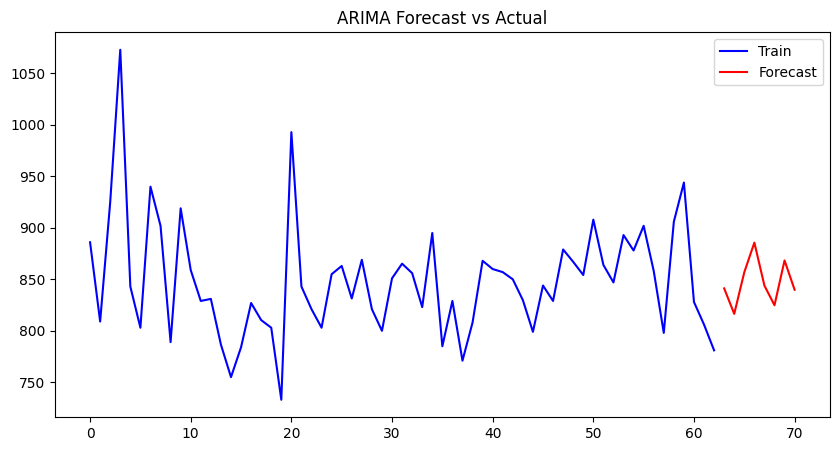

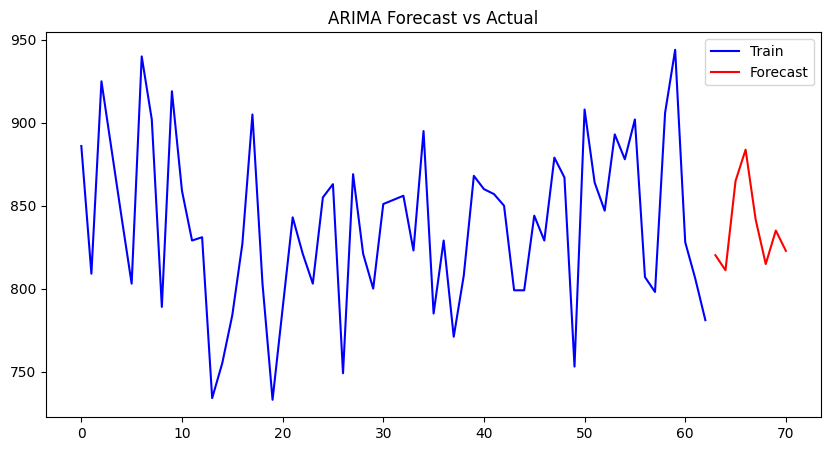

63    820.164060
64    811.094875
65    864.935089
66    883.778919
67    841.592209
68    814.837571
69    835.049927
70    822.784365
Name: predicted_mean, dtype: float64

In [19]:
mape_rolling = arima_model_forecasted_val(train_data_cleaned,test_data_cleaned,best_p_cleaned,best_d_cleaned,best_q_cleaned)

mape_iqr = arima_model_forecasted_val(train_data_cleaned_iqr,test_data_cleaned_iqr,best_p_cleaned_iqr,best_d_cleaned_iqr,best_q_cleaned_iqr)

# Now plotting the forecast for the rollig method 
model_fit = ARIMA(vehicles_per_day_cleaned, order=(best_p_cleaned, 
best_d_cleaned, best_q_cleaned) , seasonal_order=(1,1,1,7)).fit()

plot_forecasted_Data(vehicles_per_day_cleaned,7,model_fit)

# Now plotting the forecast for the IQR method 
model_fit = ARIMA(vehicles_per_day_cleaned_iqr, order=(best_p_cleaned_iqr, best_d_cleaned_iqr, best_q_cleaned_iqr) , seasonal_order=(1,1,1,7)).fit()

plot_forecasted_Data(vehicles_per_day_cleaned_iqr,7,model_fit)


Now performing the imputation , smoothing techinques for the avg_time_spent part 

The methods used for outlier detection are same , however in this case their is a scope of missing values , So I have used one missing values imputation techinques 

1. Implemented that those vehicles whose entry or exit is only marked gets their corresponding exit and entry timestamp from the nearest maintainance period , this actually completes the data and implemented above in the code.
This method also check for the possibility of one charecter getting filpped among the vehicles nos 

And then the outlier smoothing is done using the two functions described above 

In [20]:
# Grouping the entry and exit data after droping the nan values
df_without_nan = df.dropna()

df_entry = df_without_nan[df_without_nan['camera_id'] == 1].copy().rename(columns={'timestamp': 'timestamp_entry'})
df_exit = df_without_nan[df_without_nan['camera_id'] == 2].copy().rename(columns={'timestamp': 'timestamp_exit'})

# This merge also adds those vehicles which onyl have either exit or entry
merged_data = pd.merge(df_entry, df_exit, on='vehicle_no', suffixes=('_entry', '_exit'),how='outer',indicator=True)

# This contains the non mathced data
non_matched_data = merged_data[merged_data['_merge'] != 'both']



Now the above is the set of non matched data, some of them would be the vehicles which only have entry or exit, and other would be whose one character has been flipped during the entry so they were not able to pair up

So from the non_matched_data we will first pair up those vehicles who have their pair's vehicle number flipped 

In [21]:
# This function returns True, if the v1 and v2 differ by exactly one character
def is_similar(v1, v2):
    if len(v1) != len(v2):
        return False
    differences = sum(1 for a, b in zip(v1, v2) if a != b)
    return differences == 1  # Return True if they differ by exactly one character

In [22]:
# Function Group similar vehicle numbers
def group_similar_vehicle_numbers(vehicle_numbers):
    vehicle_groups = {}
    seen = set()
    
    for vehicle in vehicle_numbers:
        if vehicle in seen:
            continue
        similar_group = {vehicle}
        seen.add(vehicle)
        
        # Compare with all other vehicles
        for other_vehicle in vehicle_numbers:
            if other_vehicle in seen:
                continue
            if is_similar(vehicle, other_vehicle):
                similar_group.add(other_vehicle)
                seen.add(other_vehicle)
        
        # Use the most frequent vehicle number in the group as the representative
        representative = max(similar_group, key=lambda x: list(vehicle_numbers).count(x))
        
        # Update mapping only for vehicles that are not the representative
        for v in similar_group:
            if v != representative:  # Avoid mapping to itself
                vehicle_groups[v] = representative

    return vehicle_groups

In [23]:
unique_vehicle_numbers = non_matched_data['vehicle_no'].unique()
vehicle_number_mapping = group_similar_vehicle_numbers(unique_vehicle_numbers)
# Now updating those entries which have similar vehicle numbers (i.e. differes by one) in th original data
for index in df.index: 
    original_vehicle_no = df.loc[index, 'vehicle_no']  
    # Replace with mapped vehicle number if it exists in the mapping, else keep it the same
    df.at[index, 'vehicle_no'] = vehicle_number_mapping[original_vehicle_no] if original_vehicle_no in vehicle_number_mapping else original_vehicle_no

In [24]:
# Now after this grouping club the entry and exit data again to find those entry and exit which have their entry or exit marked during the nan 

df_without_nan = df.dropna()

df_entry = df_without_nan[df_without_nan['camera_id'] == 1].copy().rename(columns={'timestamp': 'timestamp_entry'})
df_exit = df_without_nan[df_without_nan['camera_id'] == 2].copy().rename(columns={'timestamp': 'timestamp_exit'})

# This merge also adds those vehicles which onyl have either exit or entry
merged_data = pd.merge(df_entry, df_exit, on='vehicle_no', suffixes=('_entry', '_exit'),how='outer',indicator=True)

# This contains the non mathced data
non_matched_data = merged_data[merged_data['_merge'] != 'both']

Now take the Non Matched data, divide it into the two parts one with camera id 1 and one with camera id 2, ond sort on the basis of time 

Take the nan entry divide into two parts one with camera id 1 and one with camera id 2, now sort that also 

Map the camera id 1 data of Non matched with the camera id 2 data, and
Map the camera id 2 data of Non matched with the camera id 1 data

In [25]:
non_matched_entry = non_matched_data[non_matched_data['_merge'] == 'left_only']
non_matched_exit = non_matched_data[non_matched_data['_merge'] == 'right_only']

nan_entry = df[(df['camera_id'] == 1) & (df['vehicle_no'].isna())]
nan_exit = df[(df['camera_id'] == 2) & (df['vehicle_no'].isna())]

# Last data of non_matched_entry on obersvation is found has no match in the nan data , so is dropped 
non_matched_exit = non_matched_exit.drop(non_matched_exit.index[-1])

# So we have 367 non_matched_exit and 371 nan_entry , so 4 of the nan entry should be droppend and rest should be ,matched with the remaining non_matched_exit
# Also we have 71 non_matched_entry and 70 nan_exit , so 1 of the non_matched_entry should deleted from non_matched_entry

non_matched_entry = non_matched_entry.drop(non_matched_entry.index[-1]) 
nan_entry = nan_entry.drop(nan_entry.index[-4:])

In [26]:
# Now map the entry and exit data with the nan data
# Step 1: Sort all dataframes by 'timestamp'
non_matched_entry = non_matched_entry.sort_values(by='timestamp_entry').reset_index(drop=True)
non_matched_exit = non_matched_exit.sort_values(by='timestamp_exit').reset_index(drop=True)
nan_entry = nan_entry.sort_values(by='timestamp').reset_index(drop=True)
nan_exit = nan_exit.sort_values(by='timestamp').reset_index(drop=True)

# Step 2: Assign timestamps
# Assign 'nan_exit' timestamps to 'non_matched_entry'
non_matched_entry['timestamp_exit']= nan_exit['timestamp']
non_matched_entry['camera_id_exit']= 2
non_matched_entry['camera_id_entry']= 1

# Assign 'nan_entry' timestamps to 'non_matched_exit'
non_matched_exit['timestamp_entry'] = nan_entry['timestamp']
non_matched_exit['camera_id_entry']= 1
non_matched_exit['camera_id_exit']= 2

# Droping the merge column
non_matched_exit = non_matched_exit.drop(columns=['_merge'])
non_matched_entry = non_matched_entry.drop(columns=['_merge'])

non_matched_exit.rename(columns={'camera_id_entry': 'camera_id_x', 'camera_id_exit': 'camera_id_y'}, inplace=True)
non_matched_entry.rename(columns={'camera_id_entry': 'camera_id_x', 'camera_id_exit': 'camera_id_y'}, inplace=True)

In [27]:
merged_data = pd.merge_asof(
    df_entry,
    df_exit,
    by='vehicle_no',
    left_on='timestamp_entry',
    right_on='timestamp_exit',
    direction='forward'  # Matches entry with the nearest future exit
)

merged_data.dropna(inplace=True)

# Now add this data back to the original data
merged_data = pd.concat([merged_data, non_matched_entry, non_matched_exit], ignore_index=True)
merged_data = merged_data.sort_values(by='timestamp_entry').reset_index(drop=True)

In [28]:
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60
# Calculate average time spent per day
avg_time_per_day = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['time_spent'].mean()
avg_time_per_day.index.name = 'date'


Now Implementing a outlier improvement in the model for both avg_time_spent and vehicles_per_day

1 : The method I used for Outlier Detection is rolling zscore outlier check, I have set the threshold for 1.5.
3. Now after detecting the outliers, using the moving average to fill thoes values for smoothing purposes.

2. Implemented the Interquartile Range (IQR) Method to detect the outlier
3. Now after detecting the outliers, using the Interpolation to  fill those values for smoothing purposes.


NOTE : The AVG time spent by vehicles per day data has no such significant outliers, So the plots will look almost similar in the 3 cases 



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='avg_time_per_day'>)

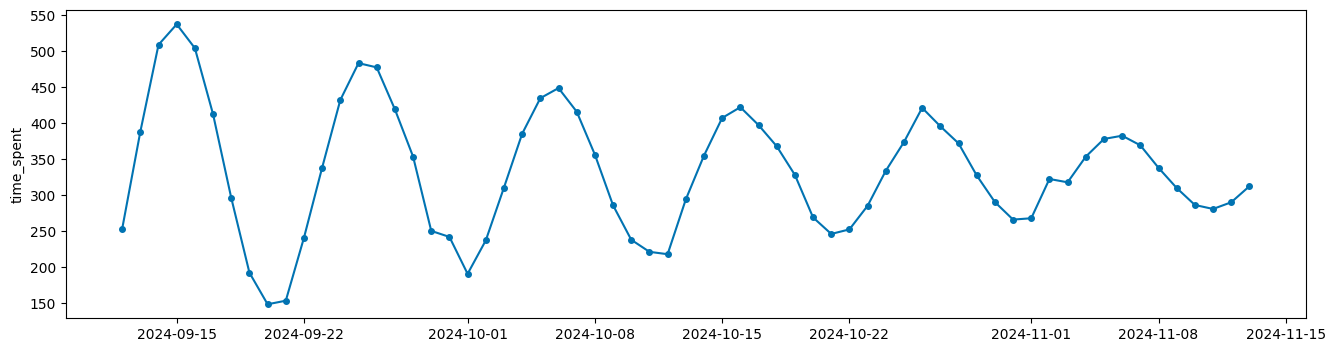

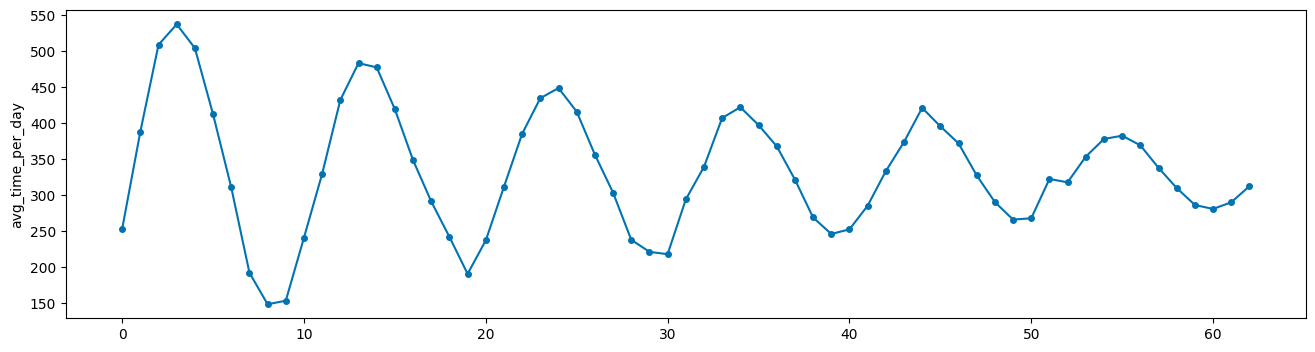

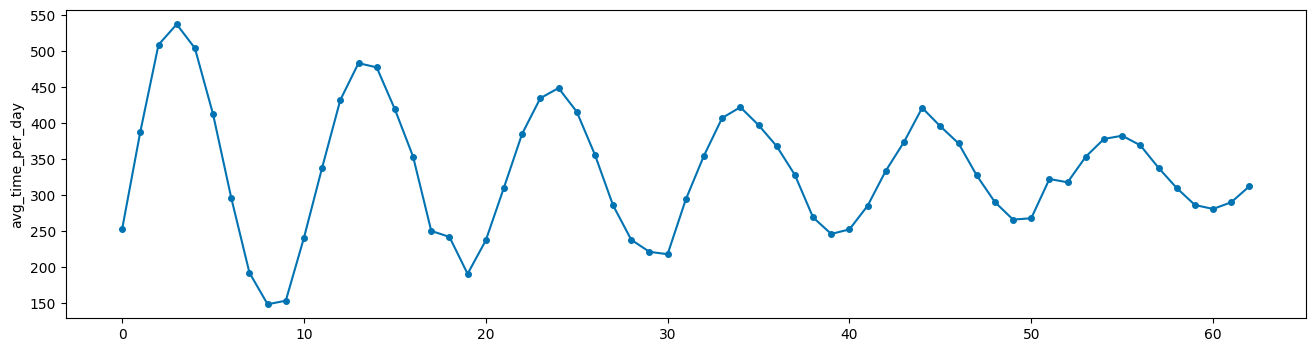

In [29]:
avg_time_per_day_df = pd.DataFrame(avg_time_per_day)

avg_time_per_day_df = avg_time_per_day_df.rename(columns={'time_spent': 'avg_time_per_day'})

avg_time_per_day_df['is_outlier'] = False


avg_time_per_day_cleaned = rolling_outlier_check(avg_time_per_day_df,'avg_time_per_day').reset_index(drop=True)
avg_time_per_day_cleaned = remove_outliers(avg_time_per_day_cleaned,'avg_time_per_day')

avg_time_per_day_cleaned_iqr = detect_outliers_iqr(avg_time_per_day_df,'avg_time_per_day').reset_index(drop=True)
avg_time_per_day_cleaned_iqr = remove_outliers_interpolate(avg_time_per_day_cleaned_iqr,'avg_time_per_day')

avg_time_per_day_df = avg_time_per_day_df.drop(columns=['is_outlier'])
avg_time_per_day.index = pd.to_datetime(avg_time_per_day.index)

# These are without smoothing  
ploting_series(avg_time_per_day)

# These are with smoothing (rolling zscore) 
ploting_series(avg_time_per_day_cleaned)

# These are with smoothing (IQR) 
ploting_series(avg_time_per_day_cleaned_iqr)

In [30]:
train_data_cleaned , test_data_cleaned = train_test(avg_time_per_day_cleaned)
train_data_cleaned_iqr , test_data_cleaned_iqr = train_test(avg_time_per_day_cleaned_iqr)

In [31]:
def best_p_d_q(train_data,test_data) : 
    mape_min = 100
    best_p = 0  
    best_q = 0
    best_d = 0
    for d in range(0,2) : 
        for p in range(0,5) : 
            for q in range(0,5) : 
                arima_model = ARIMA(train_data, order=(p, d, q) , seasonal_order=(0,1,0,5))
                arima_result = arima_model.fit()
                arima_forecast = arima_result.forecast(steps=len(test_data))
                mape_val = mape(test_data['avg_time_per_day'], arima_forecast.values)
                if mape_val < mape_min : 
                    mape_min = mape_val
                    best_p = p
                    best_q = q
                    best_d = d
    return best_p,best_d,best_q

In [32]:
best_p_cleaned , best_d_cleaned , best_q_cleaned = best_p_d_q(train_data_cleaned,test_data_cleaned)

best_p_cleaned_iqr , best_d_cleaned_iqr , best_q_cleaned_iqr  = best_p_d_q(train_data_cleaned_iqr,test_data_cleaned_iqr)

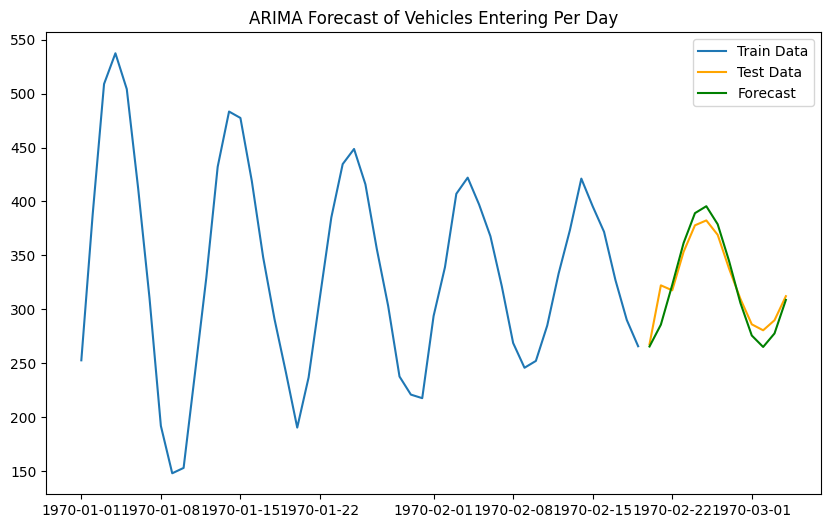

ARIMA MASE: 0.9421949493137112
ARIMA MAPE: 14.916183832622751


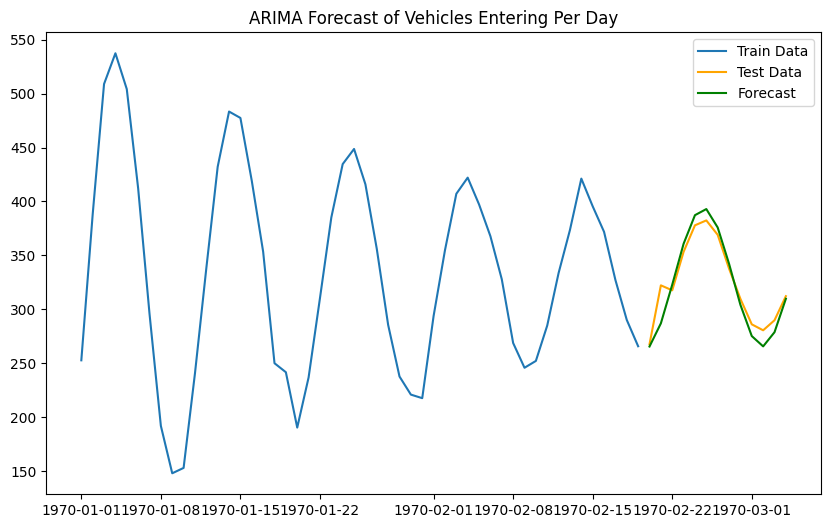

ARIMA MASE: 0.9277987008695044
ARIMA MAPE: 14.677923558341954


In [33]:
# ARIMA model for forecasting vehicles entering
mape_rolling = arima_model_forecasted_val(train_data_cleaned,test_data_cleaned,best_p_cleaned,best_d_cleaned,best_q_cleaned,P=0,Q=1,D=0,S=5)

mape_IQR = arima_model_forecasted_val(train_data_cleaned_iqr,test_data_cleaned_iqr,best_p_cleaned_iqr,best_d_cleaned_iqr,best_q_cleaned_iqr,P=0,Q=1,D=0,S=5)

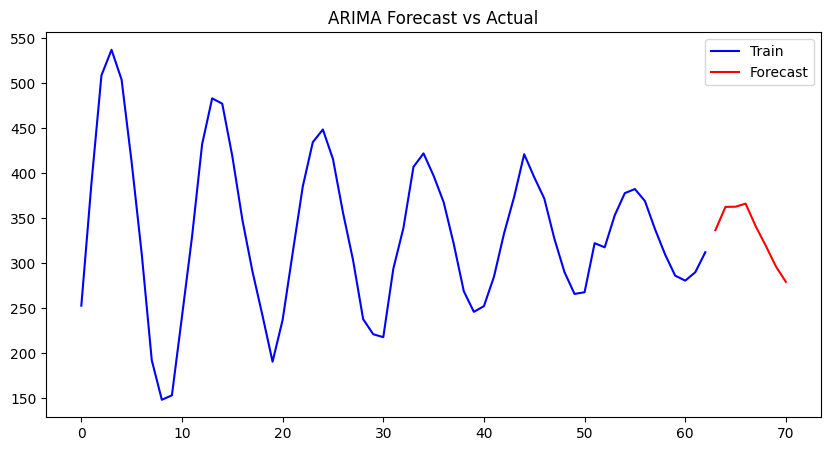

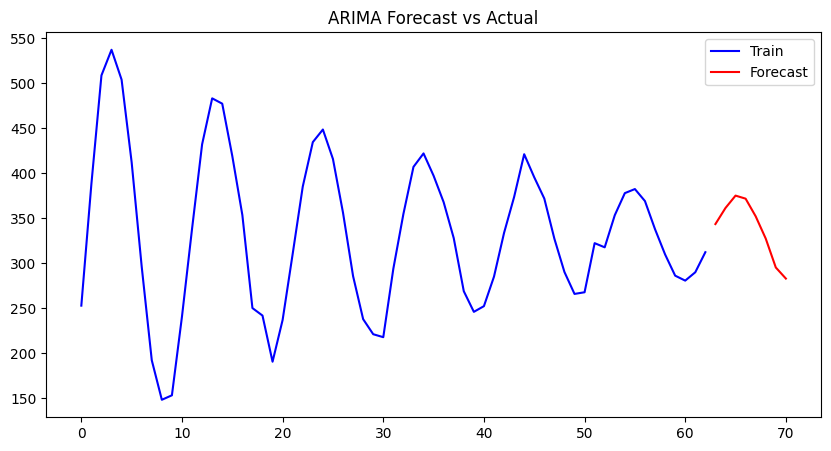

63    343.504162
64    361.384123
65    375.144246
66    371.754588
67    352.125131
68    327.334298
69    295.198742
70    282.886566
Name: predicted_mean, dtype: float64

In [34]:

# Forecating for the above data
# PLotting the forecast for 8 days , so that the forecast look continous to the actual data
model_fit = ARIMA(avg_time_per_day_cleaned, order=(best_p_cleaned, best_d_cleaned, best_q_cleaned) , seasonal_order=(0,1,0,5)).fit()
plot_forecasted_Data(avg_time_per_day_cleaned,7,model_fit)

model_fit = ARIMA(avg_time_per_day_cleaned_iqr, order=(best_p_cleaned_iqr, best_d_cleaned_iqr, best_q_cleaned) , seasonal_order=(0,1,0,5)).fit()
plot_forecasted_Data(avg_time_per_day_cleaned_iqr,7,model_fit)